In [1]:
# Sources Utilized
# https://www.youtube.com/watch?v=Usxer0D-WWM
# https://towardsdatascience.com/efficient-frontier-in-python-detailed-tutorial-84a304f03e79
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

# Imports Necessary
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import datetime as dt
import yfinance as yf

#Matplot Lib Settings
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:

# Collecting Data from Assets and 2 Year Span

assets = ['OXY','EQT','MPC','ENPH','HES','XOM','GOOG']
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(2 * 365)

adj_close = yf.download(assets, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  7 of 7 completed


In [3]:
#Calculations for Returns, Mean Returns, Covariance, and Variance as well as inputs for the upcoming tables

returns = adj_close.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
var_matrix = returns.var()
num_portfolios = 25000
risk_free_rate = 0.03

In [4]:
mean_returns

ENPH    0.003138
EQT     0.002641
GOOG    0.000490
HES     0.003109
MPC     0.002997
OXY     0.004781
XOM     0.002824
dtype: float64

In [5]:
cov_matrix

,ENPH,EQT,GOOG,HES,MPC,OXY,XOM
ENPH,0.001983,0.000240,0.000332,0.000148,0.000168,0.000265,0.000061
EQT,0.000240,0.001268,0.000101,0.000514,0.000357,0.000620,0.000346
GOOG,0.000332,0.000101,0.000375,0.000115,0.000128,0.000122,0.000080
HES,0.000148,0.000514,0.000115,0.000894,0.000567,0.000907,0.000543
MPC,0.000168,0.000357,0.000128,0.000567,0.000563,0.000664,0.000420
OXY,0.000265,0.000620,0.000122,0.000907,0.000664,0.001513,0.000661
XOM,0.000061,0.000346,0.000080,0.000543,0.000420,0.000661,0.000481


In [6]:
var_matrix

ENPH    0.001983
EQT     0.001268
GOOG    0.000375
HES     0.000894
MPC     0.000563
OXY     0.001513
XOM     0.000481
dtype: float64

/tmp/ipykernel_295187/1423877420.py:29: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.count()]
/tmp/ipykernel_295187/1423877420.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.86
Annualized Volatility: 0.37


                 ENPH       EQT      GOOG       HES       MPC       OXY  \
allocations  0.181853  0.028063  0.009383  0.008448  0.252305  0.263141   

                  XOM  
allocations  0.256808  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.46
Annualized Volatility: 0.26


                ENPH      EQT      GOOG       HES       MPC       OXY  \
allocation  0.049272  0.09251  0.442196  0.012485  0.149769  0.002524   

                 XOM  
allocation  0.251244  


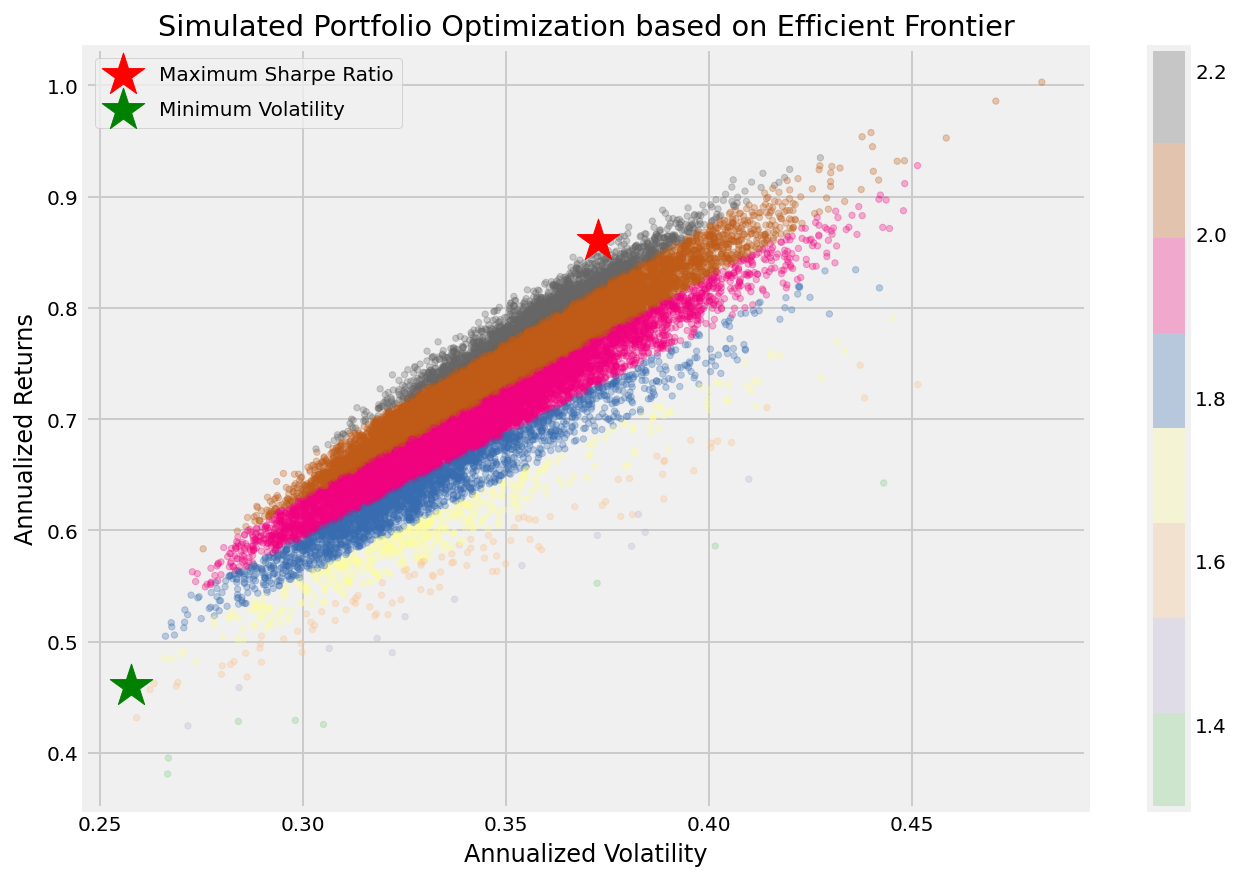

In [7]:
# Generating the randomly weighted portfolio and measure the Sharpe Ratio of thousands of portfolios to find the best optimized one
def random_portfolios(num_portfoliios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    num_assets= 7
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record



def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * (weights )) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=adj_close.columns,columns=['allocations'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.count()]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=adj_close.columns,columns=['allocation'])
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualized Return:",round(rp_min,2))
    print("Annualized Volatility:",round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:], results[1,:],c=results[2,:],cmap='Accent', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label = 'Maximum Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,marker='*', color='g',s=500, label='Minimum Volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Returns')
    plt.legend(labelspacing=0.8)

display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)